In [6]:
import librosa
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import flags

import matplotlib.pyplot as plt
import librosa.display
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed

import bcolz
import threading
from tqdm import tqdm
from pathlib import Path

from sklearn.utils import shuffle

import math
import sys


from sklearn.utils import shuffle
%matplotlib inline



## Alignment Files
These are rows of 100-121669-0000 0 0 0 0 43 45 4577 4577 4577 4577 4160 416… 
Signifying speaker, chapter, utterance and then an alignent for each timestep. We loop through all the alignments, find their corresponding .flac file location and record it. 

### Ensure your librispeech folder with all .flac files in it is in the lc_data folder.

In [8]:



# Process all .flac files into numpy files into one directory.
alignment_directory = '/home/ubuntu/lc_data/exp_cntk_aug/tri6b_ali_train_clean_460_fbank_cw_th4.5/ali_txt/'
# These alignment files correspond to http://www.openslr.org/resources/12/train-clean-100.tar.gz and http://www.openslr.org/resources/12/train-clean-360.tar.gz


audio_locations = []
labels = []


for file in tqdm(os.listdir(alignment_directory)):
    
    with open(alignment_directory + file, 'rt') as f:
        records = f.readlines()
        for record in records:
            
            (i_d, label) = record.split(' ',1)
            i_d_parts = i_d.split('-')
            if len(i_d_parts) == 3:
                (speaker, chapter, utterance) = i_d_parts
                audio_loc = '/home/ubuntu/lc_data/LibriSpeech/train-clean-360/' + speaker + '/' + chapter + '/' + i_d +'.flac'
                if Path(audio_loc).exists():
                    audio_locations.append(audio_loc)
                    labels.append(label)
                else:
                    audio_loc = audio_loc = '/home/ubuntu/lc_data/LibriSpeech/train-clean-100/' + speaker + '/' + chapter + '/' + i_d +'.flac'
                    if Path(audio_loc).exists():
                        audio_locations.append(audio_loc)
                        labels.append(label)
                    
                    
        
print(len(audio_locations))
print(len(labels))



100%|██████████| 20/20 [00:04<00:00,  4.26it/s]

28539
28539


## Convert .flac files to .npy files. 
### If you can solve why the multithreading doesn't work here (commented out), I would be very interested. 

In [ ]:
def raw_audio_to_MFCC_features(raw_audio_locations):
    

    def save_MFCC(location):
        wave, sr = librosa.core.load(location)
        spectogram = librosa.power_to_db(librosa.feature.melspectrogram(y=wave, sr=sr, n_mels=80, hop_length=int(0.010*sr), n_fft=int(0.025*sr)), ref=np.max)
        
        np.save('/home/ubuntu/lc_data/features/' +location.split('/')[-1].replace('.flac','-mel'), spectogram, allow_pickle=False)

        del wave # make sure they're closed
        del sr # make sure they're closed
        return location
        
    
#     with ThreadPoolExecutor(max_workers=16) as executor:
#         futures = [executor.submit(save_MFCC, location) for location in raw_audio_locations]

    for loc in tqdm(raw_audio_locations):
        save_MFCC(loc)
                

################################################ Run this if you want to convert .flac to 
#raw_audio_to_MFCC_features(audio_locations)
################################################

'/home/ubuntu/lc_data/LibriSpeech/train-clean-100/6272/70168/6272-70168-0000.flac'

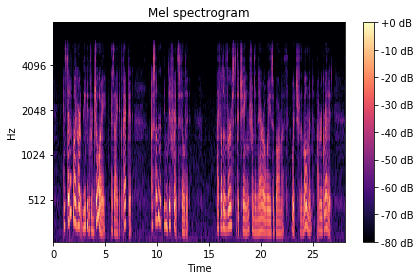

In [7]:



def display_MFCC(location):
        wave, sr = librosa.core.load(location)
        spectogram = librosa.power_to_db(librosa.feature.melspectrogram(y=wave, sr=sr, n_mels=80, hop_length=int(0.010*sr), n_fft=int(0.025*sr)), ref=np.max)
        librosa.display.specshow(spectogram, y_axis='mel', fmax=8000, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel spectrogram')
        plt.tight_layout()
        
        
        del wave # make sure they're closed
        del sr # make sure they're closed
        return location
    
display_MFCC(audio_locations[0])

## Now use Bcolz to store the data and labels for fast access during training
1. Find .npy file locations and their labels using the alignment files.

In [81]:
npy_locations = []
labels = []
for file in tqdm(os.listdir(alignment_directory)):
    
    with open(alignment_directory + file, 'rt') as f:
        records = f.readlines()
        for record in records:
            (i_d, label) = record.split(' ',1)
            i_d_parts = i_d.split('-')
            if len(i_d_parts) == 3:
                (speaker, chapter, utterance) = i_d_parts
                npy_loc = '/home/ubuntu/lc_data/features/'+ i_d +'-mel.npy'
                if Path(npy_loc).exists():
                    npy_locations.append(npy_loc)
                    labels.append(label)
                else:
                    continue
            
print(len(npy_locations))
print(len(labels))


npy_locations, labels = shuffle(npy_locations,labels)

100%|██████████| 20/20 [00:02<00:00,  7.08it/s]


132552
132552


In [ ]:
batch_length = 40
max_len = 1800
feature_length = 80


if not os.path.exists(os.getcwd() + '/labels/'):
    os.makedirs(os.getcwd() + '/labels/')
    

t1 = threading.local()
bc_train_path = os.getcwd()+'/Bcolz_train_data.dat'

t1.place = np.zeros((max_len,80), 'uint8')


arr1 = bcolz.carray(np.empty((0, max_len, feature_length), 'float32'), 
                   chunklen=batch_length, mode='w', rootdir= bc_train_path)

bc_test_path = os.getcwd()+'/Bcolz_test_data.dat'
#t2 = threading.local()
#t1.place = np.zeros((max_len,80), 'uint8')
arr2 = bcolz.carray(np.empty((0, max_len, feature_length), 'float32'), 
                   chunklen=batch_length, mode='w', rootdir= bc_test_path)

bc_valid_path = os.getcwd()+'/Bcolz_valid_data.dat'
#t3 = threading.local()
#t1.place = np.zeros((max_len,80), 'uint8')
arr3 = bcolz.carray(np.empty((0, max_len, feature_length), 'float32'), 
                   chunklen=batch_length, mode='w', rootdir= bc_valid_path)


def append_train(r):
    time_length = r.shape[0]
    padding = np.zeros([max_len - time_length, feature_length])
    padded_mfcc = np.append(r,padding, axis = 0)
    #t1.place[:] = padded_mfcc
    
    arr1.append(padded_mfcc)
    
def append_test(r):
    time_length = r.shape[0]
    padding = np.zeros([max_len - time_length, feature_length])
    padded_mfcc = np.append(r,padding, axis = 0)
    #t1.place[:] = padded_mfcc
    
    arr2.append(padded_mfcc)
    
def append_valid(r):
    time_length = r.shape[0]
    padding = np.zeros([max_len - time_length, feature_length])
    padded_mfcc = np.append(r,padding, axis = 0)
    #t1.place[:] = padded_mfcc
    
    arr3.append(padded_mfcc)

def forge_data_and_labels():
    # load all the npyfiles, put them in bcolz. 
    label_train_batches_saved_counter = 0 
    label_test_batches_saved_counter = 0 
    label_valid_batches_saved_counter = 0 
    labels_train = []
    labels_test = []
    labels_valid = []
    lengths_train = []
    lengths_test = []
    lengths_valid = []
    for index in tqdm(range(0,len(npy_locations))):
        if index <= len(npy_locations)*0.7: #### training
            data = (np.swapaxes(np.load(npy_locations[index]), 1,0))
            if data.shape[0] <= 1800:
                append_train(data)
                label_string = labels[index][:-2].split(' ')
                label_np = np.append(np.array(label_string).astype(np.float), np.zeros(max_len-len(label_string)))
                labels_train.append(label_np)
                lengths_train.append(data.shape[0])
            
        elif index <= len(npy_locations)*0.9: #### test
            data = (np.swapaxes(np.load(npy_locations[index]), 1,0))
            if data.shape[0] <= 1800:
                append_test(data)
                label_string = labels[index][:-2].split(' ')
                label_np = np.append(np.array(label_string).astype(np.float), np.zeros(max_len-len(label_string)))
                labels_test.append(label_np)
                lengths_test.append(data.shape[0])
            
        elif index <= len(npy_locations): #### validation
            data = (np.swapaxes(np.load(npy_locations[index]), 1,0))
            if data.shape[0] <= 1800:
                append_valid(data)
                label_string = labels[index][:-2].split(' ')
                label_np = np.append(np.array(label_string).astype(np.float), np.zeros(max_len-len(label_string)))
                labels_valid.append(label_np)
                lengths_valid.append(data.shape[0])
            
    print(np.array(labels_train).shape)
        
    np.array(lengths_train).dump(open('train_lengths.npy', 'wb'))
    np.array(lengths_test).dump(open('test_lengths.npy', 'wb'))
    np.array(lengths_valid).dump(open('valid_lengths.npy', 'wb'))
    np.array(labels_train).dump(open('labels/train_labels.npy', 'wb'))
    np.array(labels_test).dump(open('labels/test_labels.npy', 'wb'))
    np.array(labels_valid).dump(open('labels/valid_labels.npy', 'wb'))
    
                      
        

            
forge_data_and_labels()
arr1.flush()
arr2.flush()
arr3.flush()

  6%|▌         | 7342/132552 [26:06<7:25:14,  4.69it/s]